# ***Lite U-Net 3+ Architecture*** for *semantic segmentation*

<p align="center">
  <img src="Images/UNet3plus.png" alt="U-Net 3+" title = "U-Net 3+/ U-Net 3 Plus" width="75%"/> <br>
  <em> U-Net ++/ Nested U-Net Architecture </em>
</p>

### ***Indexing:*** 
- Encoder: 0-1-2-3-4 (*Top -> Bottom*)
- Decoder: 0-1-2-3-4 (*Bottom -> Top*)
- Bottleneck block is indiced at 4 and 0

### **Original U-Net 3+**
- Inspired by U-Net and UNet++: *UNet 3+* keeps the encoder–decoder idea, but changes how skips are used so features at different scales talk to each other more directly.

- *Full-Scale Skip Connections*: At each decoder stage, UNet 3+ collects features from all encoder scales and the deeper decoder, upsamples/downsamples them to the same size, concats, then refines with a 3×3 conv. This mixes coarse context (deep) with fine detail (shallow) right where you decode.

- *Deep Supervision* (multi-scale outputs): Each decoder stage can produce an output map. During training, these side outputs help gradients reach early layers.

- *Full-scale Aggregation*: Smaller semantic gap. Instead of many dense nested skips, UNet 3+ uses one fusion per stage (full-scale aggregation). That typically means fewer parameters, and better alignment of semantics across scales.

- *Classification-guided Module*: Relying on the output of the bottleneck, richest featues, it computes a scalar by global pooling then select the argmax of the sigmoid which indicates a prediction of whether the target exists. This is helpful for dataset where there are negative samples (no target) but for my DSB 2018 set, this can break the model.

### **Lite U-Net 3+**
- Inspired by the lightweight design of U-Lite, this variant of U-Net 3+ is similar to that Lite U-Net ++ that I once did. The amount of filters was also halved to save memory.
- *Add-ons*: Lightweight block like **SE** is applied before the skips to Full-scale Aggregation to enrich features even more. In addtion a **ResBlock + Cbam** is also applied at the BottleNeck to enhance performance of extracting features.
- *Loss*: Combo loss similar to my other code, including Boundary, Focal Tversky and Focal loss.
- For semantic segmentation, this model works very well on DSB 2018 dataset.

## Importing libraries and modules

In [593]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import v2
import cv2
import random
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchsummary import summary
from sklearn.model_selection import train_test_split
import torchvision.io as io
from scipy import ndimage as ndi

device = "cuda" if torch.cuda.is_available() else "cpu"

## Declaring static variables, tailored to the Dataset (DSB 2018)

In [594]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

TRAIN_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_train'
TRAIN_MASKS_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_train_combinedmasks'
TEST_DIR = '../data_temp/DSB_2018/data-science-bowl-2018/stage1_test'

## *Squeeze and Excitation Block*

In [595]:
class SE(nn.Module):
    def __init__(self, in_channels, out_channels, reduction = 4):
        super(SE, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_channels, out_features=out_channels//reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=out_channels//reduction, out_features=out_channels),
            nn.Sigmoid()
        )
    def forward(self, input_map):
        x = self.squeeze(input_map)
        x = self.excitation(x).unsqueeze(-1).unsqueeze(-1) #[B,C]->[B,C,1,1], unsqueeze(-1) means to unsqueeze the last dim
        return input_map*x

## **CBAM**

### *Channel Attention*
<p align="center">
  <img src="Images/ChannelAtt.png" alt="Channel Attention" title = "Channel Attention" width="75%"/> <br>
  <em> Channel Attention </em>
</p>

In [596]:
class ChannelAttention (nn.Module):
    def __init__ (self, in_channels, reduction = 2):
        super(ChannelAttention,self).__init__()
        self.global_maxpool = nn.AdaptiveMaxPool2d((1,1))
        self.global_avgpool = nn.AdaptiveAvgPool2d((1,1))
        #Input: [B,C,1,1]
        self.mlp = nn.Sequential(
            nn.Flatten(), #Size [B,C]
            nn.Linear(in_channels, in_channels//reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels//reduction,in_channels)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_map):

        x1 = self.global_maxpool(input_map)
        x2 = self.global_avgpool(input_map)

        x1 = self.mlp(x1)
        x2 = self.mlp(x2)

        out = self.sigmoid(x1 + x2).unsqueeze(2).unsqueeze(3)  # [B, C, 1, 1]

        return out

### *Spatial Attention*
<p align="center">
  <img src="Images/SpatialAtt.png" alt="Spatial Attention" title = "Spatial Attention" width="75%"/> <br>
  <em> Spatial Attention </em>
</p>

In [597]:
class SpatialAttention (nn.Module):
    def __init__ (self):
        super(SpatialAttention,self).__init__()
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride = 1, padding=3)
        self.sigmoid = nn.Sigmoid()
    def forward(self, input_map):
        x1 = torch.amax(input_map,dim = 1,keepdim=True) #[B,1,H,W]
        x2 = torch.mean(input_map,dim = 1,keepdim=True) #[B,1,H,W]
        x = torch.cat([x1,x2], dim = 1)
        x = self.conv(x)
        return self.sigmoid(x)

### ***Convolutional Block Attention Module (CBAM)***
<p align="center">
  <img src="Images/CBAM.png" alt="Convolutional Block Attention Module(CBAM)" title = "Convolutional Block Attention Module(CBAM)" width="75%"/> <br>
  <em> Convolutional Block Attention Module(CBAM) </em>
</p>

In [598]:
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction = 2)
        self.spatial_att = SpatialAttention()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.channel_att(x)*x
        x = self.spatial_att(x)*x
        return x

### ***ResBlock + CBAM***
<p align="center">
  <img src="Images/ResCBAM.png" alt="ResCBAM" title = "ResCBAM" width="85%"/> <br>
  <em> ResBlock + CBAM </em>
</p>

In [599]:
class ResCBAM(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction = 2)
        self.spatial_att = SpatialAttention()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
    
    def forward(self, skip):
        x = self.conv(skip)
        x = self.channel_att(x)*x
        x = self.spatial_att(x)*x
        return x+self.conv(skip)

### *Group Normalization / Batch Normalization / Instance Normalization*

In [600]:
# --- norm factory (GN by default) ---
def get_norm(num_channels, kind="gn", num_groups=8):
    if kind == "gn":
        # choose a divisor of num_channels
        g = min(num_groups, num_channels)
        while g > 1 and (num_channels % g) != 0:
            g -= 1
        return nn.GroupNorm(g, num_channels)
    elif kind == "in":
        return nn.InstanceNorm2d(num_channels, affine=True, track_running_stats=False)
    elif kind == "bn":
        return nn.BatchNorm2d(num_channels)
    else:
        raise ValueError(f"Unknown norm kind: {kind}")

## U-Lite inpsired **Convolution Blocks**

### *Axial Depth-wise Convolution*

In [601]:
class AxialConvDW(nn.Module):
    def __init__ (self, in_channels, axial_size = 7, dilation=1):
        super(AxialConvDW,self).__init__()

        padding = ((axial_size-1)//2)*dilation

        self.horizontal_conv = nn.Conv2d(in_channels, in_channels, 
            kernel_size=(1,axial_size), stride=1, padding = (0,padding), 
            groups=in_channels, dilation=dilation)
        
        self.vertical_conv = nn.Conv2d(in_channels, in_channels, 
            kernel_size=(axial_size,1), stride=1, padding = (padding,0), 
            groups=in_channels, dilation=dilation)
        
    def forward(self, x):
        return x+self.horizontal_conv(x)+self.vertical_conv(x)

### *Single Axial Depth-wise Convolution Block*

In [602]:
class SDWConv (nn.Module):
    def __init__ (self, in_channels, out_channels, axial_size = 3, dilation=1, act = 'gelu', norm = 'gn'):
        super().__init__()
        self.conv = nn.Sequential(
            AxialConvDW(in_channels=in_channels,axial_size=axial_size,dilation=dilation),
            get_norm(in_channels,kind=norm),
            nn.Conv2d(in_channels, out_channels, 1, 1),
            nn.GELU() if act == 'gelu' else nn.ReLU(inplace = True))
    def forward(self, x):
        return self.conv(x)

### *Double Axial Depth-wise Convolution Block*

In [603]:
class DoubleSDWConv (nn.Module):
    def __init__ (self, in_channels, out_channels, axial_size = 3, dilation = 1, act = 'gelu'):
        super().__init__()
        self.conv1 = SDWConv(in_channels, out_channels, axial_size, dilation, act)
        self.conv2 = SDWConv(out_channels, out_channels, axial_size, dilation, act)
    def forward(self, x):
        return self.conv2(self.conv1(x))

### U-Lite **BottleNeck** with added SE Block

In [604]:
class BottleNeck(nn.Module):
    def __init__ (self, in_channels, mid_channels):
        super(BottleNeck, self).__init__()
        self.pw1 = nn.Conv2d(in_channels, mid_channels//4, kernel_size=1, stride = 1)
        self.dw1 = AxialConvDW(mid_channels//4, dilation=1)
        self.dw2 = AxialConvDW(mid_channels//4, dilation=2)
        self.dw3 = AxialConvDW(mid_channels//4, dilation=3)
        self.bn = get_norm(mid_channels)
        self.pw2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=1, stride = 1)
        self.gelu = nn.GELU()
        self.cbam = ResCBAM(mid_channels)

    def forward(self, x):
        x = self.pw1(x)
        x = torch.cat([x,self.dw1(x),self.dw2(x),self.dw3(x)], dim=1)
        x = self.gelu(self.pw2(self.bn(x)))
        return self.cbam(x)

## **Encode Block**

In [605]:
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncodeBlock,self).__init__()
        self.double_conv = DoubleSDWConv(in_channels=in_channels, 
                                         out_channels=out_channels)
        self.down_sample= nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self, x):
        skip = self.double_conv(x)
        x = self.down_sample(skip)
        return x, skip

## **Decode Block** with added ResCBAM block

In [606]:
class DecodeBlock(nn.Module):
    def __init__(self,in_channels = 320, out_channels = 320):
        super(DecodeBlock,self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            SDWConv(in_channels=out_channels, out_channels=out_channels, axial_size=7)
        )
    def forward(self, x):
        return self.decode(x)

## **Full-scale Aggregation**

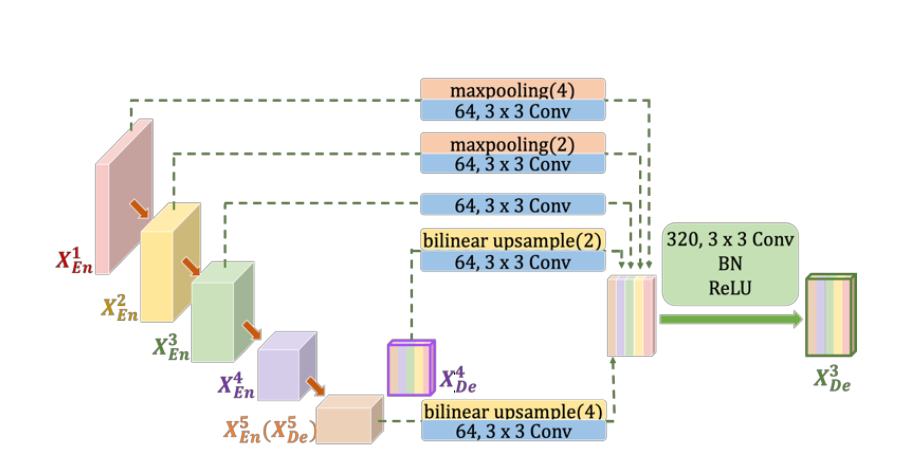

In [607]:
class FullScaleAggregation(nn.Module):
    def __init__(self, skip_idx, 
                 skips_channel = [32,64,128,256,512], 
                 de_channel = None, 
                 num_layers = 5, 
                 agg_channels = 64):
        
        super(FullScaleAggregation, self).__init__()
        if skip_idx < 1 or skip_idx >= num_layers:
            raise Exception('INVALID INDEX OF THE DECODER BLOCK\n')
        
        self.skip_idx = skip_idx
        self.encoder_aligns = nn.ModuleList()
        self.decoder_aligns = nn.ModuleList()

        # --- Encoder's aggregation ---
        for i in range (num_layers-skip_idx-1):
            align = nn.Sequential(
                SDWConv(skips_channel[i],agg_channels),
                SE(agg_channels, agg_channels, reduction=4)
            )
            self.encoder_aligns.append(align)
        
        # --- Current decoder stage's aggregation ---
        self.center_align = nn.Sequential(
            SDWConv(skips_channel[-skip_idx-1],agg_channels),
            SE(agg_channels, agg_channels, reduction=4)
        )

        # --- Decoder's aggregation ---
        bottleneck_align = nn.Sequential(
            SDWConv(skips_channel[-1],agg_channels),
            SE(agg_channels, agg_channels, reduction=4)
        )
        self.decoder_aligns.append(bottleneck_align)

        if skip_idx>1:
            if de_channel is None: de_channels = [agg_channels*num_layers]*(skip_idx-1)
            else: de_channels = [de_channel]*(skip_idx-1)
        
            for channel in de_channels:
                align = nn.Sequential(
                    SDWConv(channel,agg_channels),
                    SE(agg_channels, agg_channels, reduction=4))
                self.decoder_aligns.append(align)

    def forward(self, skips, de_skips):
        H,W = skips[-self.skip_idx-1].shape[2:]
        aligned_maps = []
        
        for i, align in enumerate(self.encoder_aligns):
            x= F.interpolate(skips[i], size = (H,W), mode='bilinear', align_corners=False)
            x = align(x)
            aligned_maps.append(x)
        
        aligned = self.center_align(skips[-self.skip_idx-1])
        aligned_maps.append(aligned)

        for i, align in enumerate(self.decoder_aligns):
            x = F.interpolate(de_skips[i], size=(H,W), mode='bilinear', align_corners=False)
            aligned_maps.append(align(x))
        
        aggregated_map = torch.cat(aligned_maps, dim =1)
        return aggregated_map

In [608]:
class CGM (nn.Module):
    def __init__ (self, in_channels, num_classes = 1, dropout_rate = 0.25):
        super(CGM, self).__init__()
        self.guide = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=in_channels, out_channels=num_classes, kernel_size=1, stride = 1, padding = 0),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.guide(x)
        return x #(B,1,1,1)

In [609]:
class DeepSupervision(nn.Module):
    def __init__ (self, in_channels, out_channels=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=1, 
                              stride=1)
    def forward(self, decode_map, mask_size):
        if decode_map.shape[2:]!=mask_size:
            decode_map = F.interpolate(decode_map, 
                                       size=mask_size, 
                                       mode='bilinear', 
                                       align_corners=False)
        return self.conv(decode_map)

In [610]:
class MultiScaleInput(nn.Module):
    def __init__(self, mid_channels, num_channels = 3):
        super().__init__()
        self.flow = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=mid_channels, kernel_size=3, stride = 1, padding = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,og_input,encode_map):
        og_input = F.interpolate(og_input, size=encode_map.shape[2:], mode='bilinear', align_corners=False)
        og_input = self.flow(og_input)
        return torch.cat([og_input, encode_map], dim = 1)

In [611]:
class UNet3Plus(nn.Module):
    def __init__ (self, num_classes = 1, in_channels = 3, 
                  deep_supervision = True, 
                  planes = [32,64,128,256,512], 
                  mask_size =(IMG_HEIGHT,IMG_WIDTH)):
        super().__init__()

        #--- Store variables ---
        self.deep_supervision = deep_supervision
        self.num_layers = 5
        self.agg_channels = planes[0]
        length = len(planes)
        self.mask_size = mask_size

        #--- Encoding ---
        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=planes[0], kernel_size=7, stride=1,padding=3),
            nn.BatchNorm2d(planes[0]),
            nn.ReLU(inplace=True))
        
        self.encode_layer1 = EncodeBlock(planes[0], planes[0])

        self.encode_layers = nn.ModuleList()
        for i in range (0, length-2):
            encode_layer = EncodeBlock(planes[i], planes[i+1])
            self.encode_layers.append(encode_layer)

        #--- BottleNeck ---
        self.bottleneck = BottleNeck(in_channels=planes[-2], mid_channels=planes[-1])
        self.CGM = CGM(in_channels=planes[-1], num_classes=1) #For DSB 2018, CGM is not needed

        #--- Decoding ---
        self.decode_layers = nn.ModuleList()
        self.intermediate_outputs = nn.ModuleList()
        self.aggregation = nn.ModuleList()
        for i in range (length-1):
            decode_layer = DecodeBlock(in_channels=self.agg_channels*self.num_layers, out_channels=self.agg_channels)
            inter_output = DeepSupervision(in_channels=self.agg_channels,out_channels=num_classes)
            aggregated_map = FullScaleAggregation(skip_idx=i+1, num_layers=5,skips_channel=planes,
                                                  de_channel=self.agg_channels, 
                                                  agg_channels=self.agg_channels)
            self.decode_layers.append(decode_layer)
            self.intermediate_outputs.append(inter_output)
            self.aggregation.append(aggregated_map)
        
    def forward(self, input):
        skips = []
        de_skips = []
        outputs = []
        x = input.clone()

        #--- Encoding ---
        x = self.first_conv(x)
        x, skip_map1 = self.encode_layer1(x)
        skips.append(skip_map1)

        for encode_layer in self.encode_layers:
            x,skip_map = encode_layer(x)
            skips.append(skip_map)
        
        #--- BottleNeck ---
        x = self.bottleneck(x)
        skips.append(x)
        de_skips.append(x)

        #--- Decoding ---
        for idx in range(len(self.decode_layers)):
            aggregated = self.aggregation[idx](skips, de_skips)
            x = self.decode_layers[idx](aggregated)
            de_skips.append(x)
            output = self.intermediate_outputs[idx](x, self.mask_size)
            outputs.append(output)
        
        if self.deep_supervision:
            return outputs
        else: 
            return outputs[-1]

In [612]:
if __name__ == "__main__":
    inputs = torch.randn((8, 3, IMG_HEIGHT, IMG_WIDTH))
    model = UNet3Plus()
    outputs = model(inputs)
    print(outputs[0].shape)
    summary(model, (3,IMG_HEIGHT,IMG_WIDTH))

torch.Size([8, 1, 128, 128])
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 32, 128, 128]        --
|    └─Conv2d: 2-1                            [-1, 32, 128, 128]        4,736
|    └─BatchNorm2d: 2-2                       [-1, 32, 128, 128]        64
|    └─ReLU: 2-3                              [-1, 32, 128, 128]        --
├─EncodeBlock: 1-2                            [-1, 32, 64, 64]          --
|    └─DoubleSDWConv: 2-4                     [-1, 32, 128, 128]        --
|    |    └─SDWConv: 3-1                      [-1, 32, 128, 128]        1,376
|    |    └─SDWConv: 3-2                      [-1, 32, 128, 128]        1,376
|    └─MaxPool2d: 2-5                         [-1, 32, 64, 64]          --
├─ModuleList: 1                               []                        --
|    └─EncodeBlock: 2-6                       [-1, 64, 32, 32]          --
|    |    └─DoubleSDWConv: 3-3                [-1, 64, 64

In [613]:
from ptflops import get_model_complexity_info

model = UNet3Plus(deep_supervision=False).eval()
mac, params = get_model_complexity_info(model, (3,IMG_HEIGHT,IMG_WIDTH),
                                        as_strings=False,
                                        print_per_layer_stat=False)
print(f"Params: {params/1e6:.2f} M")
print(f"MACs: {mac/1e9:.2f} GMac")
print(f"FLOPs: {2*mac/1e9:.2f} GFLOPs")

Params: 3.24 M
MACs: 1.32 GMac
FLOPs: 2.64 GFLOPs


In [614]:
train_dirs = next(os.walk(top = TRAIN_DIR, topdown=True))[1]
test_dirs = next(os.walk(top = TEST_DIR, topdown=True))[1]
masks_filenames = next(os.walk(top=TRAIN_MASKS_DIR,topdown=True))[2]
print(len(train_dirs), len(test_dirs), len(masks_filenames))

#----------------------------------------------------------------------------------------------
train_dirs = next(os.walk(top = TRAIN_DIR, topdown=True))[1]
train_ids, eval_ids = train_test_split(train_dirs, test_size=150, shuffle=True, random_state=18)

670 65 670


In [638]:
class DSB2018_Dataset (torch.utils.data.Dataset):
    def __init__ (self, set_type, 
                  size = (IMG_HEIGHT, IMG_WIDTH), 
                  joint_transform = None, 
                  train_ids = train_ids, 
                  eval_ids = eval_ids, 
                  binary_mask = True,
                  distance_map = False,
                  clip_dist = None,
                  normalize_phi = True):
        
        self.joint_transform = joint_transform
        self.binary_mask = binary_mask
        self.distance_map = distance_map
        self.clip_dist = clip_dist
        self.normalize_phi = normalize_phi

        # Check for dataset type and assign correct list of sample ids (folder names)
        if set_type.lower() == 'train':
            self.data_ids = train_ids  
        elif set_type.lower() == 'eval':
            self.data_ids = eval_ids
        else: raise ValueError('Dataset type must be \'train\' or \'eval\'.')

        self.img_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.BILINEAR)
        self.mask_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.NEAREST_EXACT)
        self.to_float01 = v2.ToDtype(torch.float32,scale=True) #Normalize to [0,1]

    def __len__(self):
        return len(self.data_ids)
    
    def __distance_transform__ (self, mask):
        mk = mask[0].cpu().numpy().astype(np.uint8) #[1,H,W]->[H,W]
        # _edt means Euclidean distance transform 
        inner_distance = ndi.distance_transform_edt(mk) #This returns the distance to the nearest zero-element
        outer_distance = ndi.distance_transform_edt(1-mk)
        
        phi = outer_distance-inner_distance #Positive outside of the foreground, negative on the inside
        D = np.abs(phi)

        if self.clip_dist is not None:
            phi = np.clip(phi,-self.clip_dist,self.clip_dist)
            D   = np.clip(D,0.0,self.clip_dist)

        if self.normalize_phi:
            abs_mean = np.mean(np.abs(phi)) + 1e-8
            phi = phi / abs_mean

        phi = torch.from_numpy(phi).unsqueeze(0).to(mask.dtype)
        D = torch.from_numpy(D).unsqueeze(0).to(mask.dtype)

        return phi,D
    
    def __getitem__(self, index):

        img_id = self.data_ids[index]
        img_path = os.path.join(TRAIN_DIR, img_id, 'images', f'{img_id}.png')
        mask_path =  os.path.join(TRAIN_MASKS_DIR, f'{img_id}.png')

        image = io.decode_image(img_path, mode= 'RGB')
        mask = io.decode_image(mask_path, mode = 'GRAY')

        if self.joint_transform is not None:
            image, mask = self.joint_transform(image, mask)

            if self.distance_map and self.binary_mask:
                phi,D = self.__distance_transform__(mask)
                return image, mask, phi, D
            
            return image, mask
        else:
            image = self.img_resize(image)
            image = self.to_float01(image)
            
            mask = self.mask_resize(mask)
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
            
           # ---Mask binarization & handling dtype--- (Last for safety)
            if self.binary_mask:
                mask = (mask>0).to(torch.float32) 
            else: # Multi-class segment, which would expect mask to be of long dtype
                mask = mask.to(torch.long)
            
            if self.distance_map and self.binary_mask:
                phi,D = self.__distance_transform__(mask)
                return image, mask, phi, D
            
            '''[3,H,w] & [1,H,W]'''
            return image, mask 


In [639]:
class JointTransform: # Takes both numpy and torch tensors

    def __init__(self,  size = (IMG_HEIGHT,IMG_WIDTH), binary_mask = True):
        self.size = size #True size
        self.normalize = v2.Normalize(mean = [0.485, 0.456, 0.406], 
                                      std = [0.229, 0.224, 0.225])
        self.img_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.BILINEAR)#Resizing size is bigger because we want to perform random crop
        self.mask_resize = v2.Resize(size=size, interpolation=v2.InterpolationMode.NEAREST_EXACT)
        self.to_float01 = v2.ToDtype(torch.float32,scale=True) #Normalize to [0,1]
        self.binary_mask = binary_mask
    
    def _to_torch_tensor(self, input): # Accept both numpy arrays and tensors
        if isinstance(input, np.ndarray):
            tensor = torch.from_numpy(input) #(H,W,C) - numpy array or (H,W)
            if tensor.ndim == 2: #(H,W)
                tensor = tensor.unsqueeze(-1) #(H,W,1)
            tensor = tensor.permute(2,0,1) #(1,H,W)
        else: # Tensor (C,H,W)
            tensor = input
            if tensor.ndim == 2: #(H,W)
                tensor = tensor.unsqueeze(0) #(1,H,W)
        return tensor
        
    def __call__(self, image, mask):
        #Convert ndarray to tensor
        image = self._to_torch_tensor(image)
        image = self.to_float01(image)

        mask = self._to_torch_tensor(mask)
        mask = mask[:1,:,:] #Ensure that mask has only one channel

        # ---Resizing---
        if image.shape[1:] != (IMG_HEIGHT,IMG_WIDTH):
            image = self.img_resize(image)
        if mask.shape[1:] != (IMG_HEIGHT,IMG_WIDTH):
            mask = self.mask_resize(mask)

        # ---Random crop---
        # i,j are the coordinates that signifies where to start cropping
        i,j,h,w = v2.RandomCrop.get_params(image, output_size=self.size)
        image = TF.crop(image, i,j,h,w)
        mask = TF.crop(mask, i,j,h,w)
        
        # ---Random horizontal flip---
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # ---Random vertical flip---
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # ---Random rotation---
        if random.random() > 0.5:
            angle = random.uniform(-10, 10)
            image = TF.rotate(image, angle=angle,
                             interpolation=v2.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle=angle, 
                            interpolation=v2.InterpolationMode.NEAREST)

        # ---Mask binarization & handling dtype--- (Last for safety)
        if self.binary_mask:
            mask = (mask>0).to(torch.float32) 
        else: # Multi-class segment, which would expect mask to be of long dtype
            mask = mask.to(torch.long)

        # ---Normalized the image---
        image = self.normalize(image)
      
        '''[3,H,w] & [1,H,W]'''
        return image, mask

In [617]:
def Dice_IoU(pred, mask, epsilon = 1e-6):
    # Case 1: Pred's shape is [N,2,H,W], binary is 2 classes, this was treated like multi class segmentation
    if pred.ndim == 4 and pred.shape[1]==2:
        pred = pred.argmax(dim = 1).unsqueeze(1) # [N,2,H,W] -> [N,H,W]

    # Case 2: Pred's shape is [N,H,W] -> [N,1,H,W]
    elif pred.ndim == 4 and pred.shape[1]==1:
        pred = pred.squeeze(1) # [N,1,H,w] -> [N,H,W]
    
    pred = pred.to(torch.float32)

    if pred.dtype.is_floating_point and (pred.min()<0 or pred.max()>1): # Check if the pred pixel values are float, neccessary for sigmoid function
        pred = torch.sigmoid(pred)
        pred = (pred >= 0.5)

    mask = (mask > 0).to(torch.float32)

    intersection = (pred*mask).sum(dim=(1,2))
    union = pred.sum(dim=(1,2)) + mask.sum(dim=(1,2))
    
    dice = (2*intersection + epsilon)/(union + epsilon) # [N], dice score for each sample in the batch
    iou = (intersection + epsilon) / (union - intersection + epsilon)

    return dice.mean().item(), iou.mean().item()

In [618]:
'''---Focal Loss---'''
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma= 4/3, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Can be a list/tuple or scalar
        self.reduction = reduction

    def forward(self, pred, mask):
        '''
        logits: [B, H, W] (Raw information), mask: [B, H, W] 
        '''
        if pred.ndim==4 and pred.shape[1]==1: 
            pred = pred.squeeze(1) #[N,1,H,W] -> [N,H,W]
        elif pred.ndim != 3: 
            raise ValueError('Predicted logit is expected to be in the size [N,1,H,W] or [N,H,W]')

        if mask.ndim==4 and mask.shape[1]==1: 
            mask = mask.squeeze(1) # [N,1,H,W] -> [N,H,W]
        elif mask.ndim !=3: 
            raise ValueError('Ground truth mask is expected to be in the size [N,1,H,W] or [N,H,W]')
        
        mask = mask.to(torch.float32) # Ensure the right dtype of mask, BCE loss requires float

        bce = nn.functional.binary_cross_entropy_with_logits(pred, mask, reduction='none')  # [N,]
        pt = torch.exp(-bce)  # pt = prob of true class

        if self.alpha is not None:
            at = self.alpha*mask + (1-self.alpha)*(1-mask)
        else: at = 1.0

        loss = (at*(1 - pt) ** self.gamma *(bce))

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        
        return loss  # no reduction

In [619]:
'''---Focal Tversky Loss---'''
class FTL(nn.Module):
    def __init__(self, alpha = 0.3, beta = 0.7, gamma = 4/3, epsilon = 1e-6, from_logits = True, reduction = 'mean'):
        super(FTL, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.from_logits = from_logits
        self.reduction = reduction
    
    def forward (self, pred, mask): 
        '''
        Both pred and mask are converted into tensors before passing in
        Mask's input shape: [N,H,W]
        Logits(Predicted image)'s shape: [N,1,H,W]
        logits: [N, H, W] (Raw information), mask: [N, H, W] 
        '''

        # Shape
        if pred.ndim==4 and pred.shape[1]==1:
            pred = pred[:,0,:,:] #[N,1,H,W] -> [N,H,W]
        elif pred.ndim != 3: 
            raise ValueError('Predicted logit is expected to be in the size [N,1,H,W] or [N,H,W]')

        if mask.ndim==4 and mask.shape[1]==1:
            mask = mask[:,0,:,:] # [N,1,H,W] -> [N,H,W]
        elif mask.ndim !=3: 
            raise ValueError('Ground truth mask is expected to be in the size [N,1,H,W] or [N,H,W]')
        
        # Datatypes
        pred = pred.to(torch.float32)
        mask = mask.to(torch.float32)

        # logits -> Probability
        if self.from_logits: 
            prob = torch.sigmoid(pred)
        else: prob = pred.clamp(0,1)
        
        # FTL
        tp = (prob*mask).sum(dim =(1,2)) #[N,]
        fp = (prob*(1.0-mask)).sum(dim=(1,2)) 
        fn = (mask*(1.0-prob)).sum(dim=(1,2))
        tversky_index = (tp+self.epsilon)/(tp+self.alpha*fp+self.beta*fn+self.epsilon) #[N,]
        loss = (1-tversky_index)**(1/self.gamma)
        
        # Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        
        return loss  # no reduction

In [620]:
class BoundaryLoss(nn.Module):
    """
    L = <phi_G, s_theta>
    - Binary: logits [B,1,H,W], phi [B,1,H,W]
    - Multi : logits [B,C,H,W], phi [B,C,H,W] (one phi per class)
    Expect phi already prepared (signed; you normalized it in the Dataset).
    """
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction

    def forward(self, logits, phi):
        probs = torch.sigmoid(logits) if logits.shape[1] == 1 else F.softmax(logits, dim=1)
        loss_map = probs * phi                      # <phi, s>
        loss = loss_map.mean(dim=(1,2,3))          # per-sample
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

In [621]:
def get_model(UNet = UNet3Plus,device = 'cuda',lr = 1e-3,weight_decay = 1e-5, optim = 'Adam'):
    
    #--- Model ---
    model = UNet().to(device)
    
    #--- Loss functions ---
    focal_tversky_loss = FTL(alpha = 0.3, beta=0.7, gamma=4/3)
    focal_loss = BCEFocalLoss(alpha=0.75, gamma=2) 
    boundary_loss = BoundaryLoss(reduction='mean')
    
    #--- Optimizers ---
    if optim == 'Adam':
        optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay) 
    elif optim == 'SGD':
        optimizer = SGD(model.parameters(), momentum=0.9, nesterov=True,lr = lr, weight_decay = weight_decay) 
    else: 
        raise ValueError('Unsupported Optimizer')
    
    return model, focal_tversky_loss, focal_loss, boundary_loss, optimizer

In [622]:
def train_batch(model,data_batch,optimizer,
                focal_tversky_loss,focal_loss,boundary_loss,
                device = 'cuda',
                head_weights = [0.1,0.1,0.2,0.6],
                w_bdry = 0.5, w_ftl = 0.7, w_fl = 0.3):
    model.train()
    img, mask, phi, D = data_batch
    img = img.to(device)
    mask = mask.to(device)
    phi = phi.to(device)
    D = D.to(device)
    
    if mask.ndim == 4 and mask.shape[1] == 1:
        mask = mask.squeeze(1)  # -> [N,H,W]
        
    mask = (mask > 0).to(torch.float32)

    optimizer.zero_grad()
    

    logits = model(img) 
    total_loss = 0.0

    for logit, w in zip(logits,head_weights):
        if logit.shape[2:]!=mask.shape[1:]:
            logit = F.interpolate(logit, size=mask.shape[1:], mode='bilinear', align_corners=False)
        loss = w_ftl*focal_tversky_loss(logit, mask) + w_fl*focal_loss(logit,mask) + w_bdry*boundary_loss(logit, phi)
        total_loss += loss*w

    total_loss.backward()
    optimizer.step() 

    final_logit = logits[-1]
    final_pred = (torch.sigmoid(final_logit)>=0.5)
    dice, iou = Dice_IoU(final_pred,mask)
    pixel_acc = (final_pred==mask).float().mean()

    return total_loss.item(), dice, iou, pixel_acc

## ***Training***

### Loading data into batches

In [623]:
train_data = DSB2018_Dataset(set_type='train', 
                             joint_transform= JointTransform(),
                             distance_map=True,
                             binary_mask=True)
trn_dl = DataLoader(train_data, batch_size = 16, shuffle = True)
img, mk, phi, D = next(iter(trn_dl))

In [624]:
#Warming up for boundary loss
def ramp_weight(epoch, start=3, end=15, max_w=0.2):
    if epoch < start:
        return 0.0
    if epoch >= end:
        return max_w
    # linear ramp
    return max_w * (epoch - start) / (end - start)

In [626]:
model, ftl, focal_loss, boundary_loss, optimizer = get_model(UNet=UNet3Plus, lr=1e-3)
train_losses, train_dice_score, train_iou, train_accuracies = [],[],[],[]

epochs = 100

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor = 0.8,patience = 10, threshold=5e-3)

model.train()

img, mask, _,_ =next(iter(trn_dl))
print(img.shape, mask.shape)  # Should print torch.Size([B, 3, 224, 224]), torch.Size([B, 1, 224, 224])

w_ftl = 0.7
w_fl = 0.3

head_weights = [0.1,0.1,0.2,0.6]

for epoch in range(epochs):
    loss_sum = acc_sum = dice_sum = iou_sum = 0.0
    n = 0

    w_bdry = ramp_weight(epoch, start = 3, end = 15, max_w = 0.5)

    for batch in tqdm(trn_dl, desc=f'CURRENT EPOCH: {epoch}'):
        loss, dice, iou, acc = train_batch(model, batch, optimizer, 
                                      focal_tversky_loss=ftl, 
                                      focal_loss=focal_loss,
                                      boundary_loss=boundary_loss,
                                      head_weights=head_weights,
                                      w_ftl = w_ftl, w_fl = w_fl, w_bdry = w_bdry)
        
        # --- Convert to CPU and to float ---
        if torch.is_tensor(loss): loss = float(loss.detach().cpu())
        if torch.is_tensor(acc):  acc  = float(acc.detach().cpu())
        if torch.is_tensor(dice): dice = float(dice.detach().cpu())
        if torch.is_tensor(iou): iou = float(iou.detach().cpu())


        # train_batch should already return plain floats
        loss_sum += loss
        acc_sum  += acc
        dice_sum += dice
        iou_sum += iou
        n += 1

    epoch_loss = loss_sum / n
    epoch_acc  = acc_sum  / n
    epoch_dice = dice_sum / n
    epoch_iou = iou_sum / n

    train_losses.append(np.array(epoch_loss).item())
    train_accuracies.append(np.array(epoch_acc).item())
    train_dice_score.append(np.array(epoch_dice).item())
    train_iou.append(np.array(epoch_iou).item())

    scheduler.step(epoch_dice)

    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
    print(f'Epoch loss = {epoch_loss:.4f}, pixel accuracy = {epoch_acc*100:.4f}%')
    print(f'Dice score = {epoch_dice*100:.4f}%, IoU = {epoch_iou*100:.4f}%\n')


torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])


CURRENT EPOCH: 0: 100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Learning rate: 0.001000
Epoch loss = 0.4682, pixel accuracy = 46.7071%
Dice score = 49.7151%, IoU = 37.8239%



CURRENT EPOCH: 1: 100%|██████████| 33/33 [00:09<00:00,  3.39it/s]


Learning rate: 0.001000
Epoch loss = 0.2674, pixel accuracy = 67.8282%
Dice score = 81.1725%, IoU = 70.0929%



CURRENT EPOCH: 2: 100%|██████████| 33/33 [00:09<00:00,  3.32it/s]


Learning rate: 0.001000
Epoch loss = 0.1770, pixel accuracy = 68.2080%
Dice score = 86.2397%, IoU = 77.2075%



CURRENT EPOCH: 3: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.001000
Epoch loss = 0.1688, pixel accuracy = 68.0874%
Dice score = 86.3279%, IoU = 77.4223%



CURRENT EPOCH: 4: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.1532, pixel accuracy = 68.2777%
Dice score = 87.6959%, IoU = 79.3375%



CURRENT EPOCH: 5: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.1399, pixel accuracy = 68.3750%
Dice score = 88.5840%, IoU = 80.6509%



CURRENT EPOCH: 6: 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]


Learning rate: 0.001000
Epoch loss = 0.1417, pixel accuracy = 68.3034%
Dice score = 87.9644%, IoU = 79.8446%



CURRENT EPOCH: 7: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.001000
Epoch loss = 0.1294, pixel accuracy = 68.4104%
Dice score = 88.7196%, IoU = 80.7761%



CURRENT EPOCH: 8: 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]


Learning rate: 0.001000
Epoch loss = 0.1240, pixel accuracy = 68.5237%
Dice score = 89.0281%, IoU = 81.3168%



CURRENT EPOCH: 9: 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]


Learning rate: 0.001000
Epoch loss = 0.1204, pixel accuracy = 68.2008%
Dice score = 88.6617%, IoU = 80.7896%



CURRENT EPOCH: 10: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.001000
Epoch loss = 0.1164, pixel accuracy = 68.6408%
Dice score = 88.9482%, IoU = 81.2744%



CURRENT EPOCH: 11: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.001000
Epoch loss = 0.1086, pixel accuracy = 68.4546%
Dice score = 89.2395%, IoU = 81.6003%



CURRENT EPOCH: 12: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.001000
Epoch loss = 0.1017, pixel accuracy = 68.7470%
Dice score = 89.6414%, IoU = 82.1220%



CURRENT EPOCH: 13: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.0959, pixel accuracy = 68.6049%
Dice score = 89.7383%, IoU = 82.2664%



CURRENT EPOCH: 14: 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]


Learning rate: 0.001000
Epoch loss = 0.0918, pixel accuracy = 68.5859%
Dice score = 89.8391%, IoU = 82.4567%



CURRENT EPOCH: 15: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.0875, pixel accuracy = 68.6636%
Dice score = 89.9035%, IoU = 82.5001%



CURRENT EPOCH: 16: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.001000
Epoch loss = 0.0934, pixel accuracy = 68.6588%
Dice score = 89.0915%, IoU = 81.3748%



CURRENT EPOCH: 17: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.0918, pixel accuracy = 68.6641%
Dice score = 89.3568%, IoU = 82.0361%



CURRENT EPOCH: 18: 100%|██████████| 33/33 [00:09<00:00,  3.58it/s]


Learning rate: 0.001000
Epoch loss = 0.0920, pixel accuracy = 68.6188%
Dice score = 89.3225%, IoU = 81.6717%



CURRENT EPOCH: 19: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.001000
Epoch loss = 0.0858, pixel accuracy = 68.6305%
Dice score = 89.9722%, IoU = 82.5610%



CURRENT EPOCH: 20: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.001000
Epoch loss = 0.0817, pixel accuracy = 68.8745%
Dice score = 90.3882%, IoU = 83.1539%



CURRENT EPOCH: 21: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.001000
Epoch loss = 0.0826, pixel accuracy = 68.5591%
Dice score = 90.2247%, IoU = 82.9558%



CURRENT EPOCH: 22: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.001000
Epoch loss = 0.0876, pixel accuracy = 68.7397%
Dice score = 89.9310%, IoU = 82.6108%



CURRENT EPOCH: 23: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.001000
Epoch loss = 0.0828, pixel accuracy = 68.7438%
Dice score = 90.1759%, IoU = 82.8588%



CURRENT EPOCH: 24: 100%|██████████| 33/33 [00:09<00:00,  3.59it/s]


Learning rate: 0.001000
Epoch loss = 0.0810, pixel accuracy = 68.8494%
Dice score = 90.4496%, IoU = 83.2619%



CURRENT EPOCH: 25: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.001000
Epoch loss = 0.0794, pixel accuracy = 68.8401%
Dice score = 90.7417%, IoU = 83.7236%



CURRENT EPOCH: 26: 100%|██████████| 33/33 [00:09<00:00,  3.58it/s]


Learning rate: 0.001000
Epoch loss = 0.0808, pixel accuracy = 68.6102%
Dice score = 90.3488%, IoU = 83.1389%



CURRENT EPOCH: 27: 100%|██████████| 33/33 [00:09<00:00,  3.44it/s]


Learning rate: 0.001000
Epoch loss = 0.0796, pixel accuracy = 68.8479%
Dice score = 90.5274%, IoU = 83.3192%



CURRENT EPOCH: 28: 100%|██████████| 33/33 [00:09<00:00,  3.41it/s]


Learning rate: 0.001000
Epoch loss = 0.0808, pixel accuracy = 68.6426%
Dice score = 90.3448%, IoU = 83.0875%



CURRENT EPOCH: 29: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.001000
Epoch loss = 0.0811, pixel accuracy = 68.7387%
Dice score = 90.4283%, IoU = 83.3296%



CURRENT EPOCH: 30: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.001000
Epoch loss = 0.0804, pixel accuracy = 68.8045%
Dice score = 90.5239%, IoU = 83.4052%



CURRENT EPOCH: 31: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000800
Epoch loss = 0.0806, pixel accuracy = 68.8645%
Dice score = 90.3911%, IoU = 83.1654%



CURRENT EPOCH: 32: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000800
Epoch loss = 0.0771, pixel accuracy = 68.7845%
Dice score = 90.7458%, IoU = 83.7153%



CURRENT EPOCH: 33: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.000800
Epoch loss = 0.0764, pixel accuracy = 68.9183%
Dice score = 90.8658%, IoU = 83.8744%



CURRENT EPOCH: 34: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000800
Epoch loss = 0.0763, pixel accuracy = 68.8187%
Dice score = 90.7323%, IoU = 83.7111%



CURRENT EPOCH: 35: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.000800
Epoch loss = 0.0770, pixel accuracy = 68.8626%
Dice score = 90.8520%, IoU = 83.8778%



CURRENT EPOCH: 36: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.000800
Epoch loss = 0.0746, pixel accuracy = 68.8971%
Dice score = 90.9979%, IoU = 84.0901%



CURRENT EPOCH: 37: 100%|██████████| 33/33 [00:09<00:00,  3.58it/s]


Learning rate: 0.000800
Epoch loss = 0.0767, pixel accuracy = 68.7950%
Dice score = 90.7464%, IoU = 83.7521%



CURRENT EPOCH: 38: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000800
Epoch loss = 0.0767, pixel accuracy = 68.6607%
Dice score = 90.6852%, IoU = 83.7370%



CURRENT EPOCH: 39: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.000800
Epoch loss = 0.0767, pixel accuracy = 68.7579%
Dice score = 90.7113%, IoU = 83.6861%



CURRENT EPOCH: 40: 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]


Learning rate: 0.000800
Epoch loss = 0.0734, pixel accuracy = 68.7816%
Dice score = 91.1162%, IoU = 84.2885%



CURRENT EPOCH: 41: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000800
Epoch loss = 0.0746, pixel accuracy = 69.0227%
Dice score = 90.9423%, IoU = 83.9769%



CURRENT EPOCH: 42: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.000800
Epoch loss = 0.0743, pixel accuracy = 68.8280%
Dice score = 91.0643%, IoU = 84.2550%



CURRENT EPOCH: 43: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000800
Epoch loss = 0.0752, pixel accuracy = 68.7128%
Dice score = 90.9194%, IoU = 83.9657%



CURRENT EPOCH: 44: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000640
Epoch loss = 0.0728, pixel accuracy = 68.7001%
Dice score = 91.0217%, IoU = 84.1346%



CURRENT EPOCH: 45: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000640
Epoch loss = 0.0731, pixel accuracy = 68.8289%
Dice score = 91.2163%, IoU = 84.4261%



CURRENT EPOCH: 46: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000640
Epoch loss = 0.0722, pixel accuracy = 68.8614%
Dice score = 91.2715%, IoU = 84.5134%



CURRENT EPOCH: 47: 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]


Learning rate: 0.000640
Epoch loss = 0.0721, pixel accuracy = 68.7702%
Dice score = 91.2390%, IoU = 84.4320%



CURRENT EPOCH: 48: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000640
Epoch loss = 0.0758, pixel accuracy = 68.8668%
Dice score = 90.9267%, IoU = 84.0075%



CURRENT EPOCH: 49: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000640
Epoch loss = 0.0726, pixel accuracy = 68.7859%
Dice score = 91.1784%, IoU = 84.4198%



CURRENT EPOCH: 50: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000640
Epoch loss = 0.0732, pixel accuracy = 68.9100%
Dice score = 90.9723%, IoU = 84.0848%



CURRENT EPOCH: 51: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000640
Epoch loss = 0.0717, pixel accuracy = 68.6747%
Dice score = 91.1356%, IoU = 84.3183%



CURRENT EPOCH: 52: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000640
Epoch loss = 0.0722, pixel accuracy = 68.8217%
Dice score = 91.2232%, IoU = 84.4750%



CURRENT EPOCH: 53: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.000640
Epoch loss = 0.0720, pixel accuracy = 68.8051%
Dice score = 91.2149%, IoU = 84.4673%



CURRENT EPOCH: 54: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000640
Epoch loss = 0.0705, pixel accuracy = 68.6442%
Dice score = 91.2075%, IoU = 84.4161%



CURRENT EPOCH: 55: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000512
Epoch loss = 0.0718, pixel accuracy = 68.6921%
Dice score = 91.2157%, IoU = 84.5267%



CURRENT EPOCH: 56: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000512
Epoch loss = 0.0712, pixel accuracy = 68.9975%
Dice score = 91.3092%, IoU = 84.6113%



CURRENT EPOCH: 57: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000512
Epoch loss = 0.0700, pixel accuracy = 68.8382%
Dice score = 91.4761%, IoU = 84.8388%



CURRENT EPOCH: 58: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000512
Epoch loss = 0.0701, pixel accuracy = 68.9304%
Dice score = 91.3593%, IoU = 84.6289%



CURRENT EPOCH: 59: 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]


Learning rate: 0.000512
Epoch loss = 0.0705, pixel accuracy = 69.0003%
Dice score = 91.3621%, IoU = 84.6650%



CURRENT EPOCH: 60: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000512
Epoch loss = 0.0705, pixel accuracy = 68.7541%
Dice score = 91.2360%, IoU = 84.4474%



CURRENT EPOCH: 61: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000512
Epoch loss = 0.0699, pixel accuracy = 68.6790%
Dice score = 91.3696%, IoU = 84.7688%



CURRENT EPOCH: 62: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000512
Epoch loss = 0.0707, pixel accuracy = 68.9572%
Dice score = 91.2736%, IoU = 84.5242%



CURRENT EPOCH: 63: 100%|██████████| 33/33 [00:09<00:00,  3.53it/s]


Learning rate: 0.000512
Epoch loss = 0.0704, pixel accuracy = 68.9492%
Dice score = 91.2963%, IoU = 84.5392%



CURRENT EPOCH: 64: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000512
Epoch loss = 0.0720, pixel accuracy = 68.8326%
Dice score = 91.2803%, IoU = 84.5381%



CURRENT EPOCH: 65: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000512
Epoch loss = 0.0702, pixel accuracy = 68.6741%
Dice score = 91.3197%, IoU = 84.5546%



CURRENT EPOCH: 66: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000512
Epoch loss = 0.0696, pixel accuracy = 68.7879%
Dice score = 91.4894%, IoU = 84.8731%



CURRENT EPOCH: 67: 100%|██████████| 33/33 [00:09<00:00,  3.57it/s]


Learning rate: 0.000512
Epoch loss = 0.0678, pixel accuracy = 68.5668%
Dice score = 91.4733%, IoU = 84.9288%



CURRENT EPOCH: 68: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000410
Epoch loss = 0.0717, pixel accuracy = 68.8466%
Dice score = 91.2352%, IoU = 84.4328%



CURRENT EPOCH: 69: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000410
Epoch loss = 0.0702, pixel accuracy = 68.7984%
Dice score = 91.3307%, IoU = 84.6244%



CURRENT EPOCH: 70: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000410
Epoch loss = 0.0691, pixel accuracy = 68.8146%
Dice score = 91.4760%, IoU = 84.8602%



CURRENT EPOCH: 71: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.000410
Epoch loss = 0.0696, pixel accuracy = 68.9298%
Dice score = 91.4921%, IoU = 84.8645%



CURRENT EPOCH: 72: 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]


Learning rate: 0.000410
Epoch loss = 0.0677, pixel accuracy = 68.8378%
Dice score = 91.6208%, IoU = 85.0628%



CURRENT EPOCH: 73: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000410
Epoch loss = 0.0667, pixel accuracy = 68.6602%
Dice score = 91.6210%, IoU = 85.1279%



CURRENT EPOCH: 74: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000410
Epoch loss = 0.0675, pixel accuracy = 68.7667%
Dice score = 91.6228%, IoU = 85.0449%



CURRENT EPOCH: 75: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000410
Epoch loss = 0.0684, pixel accuracy = 68.7483%
Dice score = 91.4765%, IoU = 84.8222%



CURRENT EPOCH: 76: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000410
Epoch loss = 0.0678, pixel accuracy = 68.8197%
Dice score = 91.5785%, IoU = 84.9979%



CURRENT EPOCH: 77: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000410
Epoch loss = 0.0671, pixel accuracy = 68.9156%
Dice score = 91.6706%, IoU = 85.1564%



CURRENT EPOCH: 78: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000410
Epoch loss = 0.0672, pixel accuracy = 68.8086%
Dice score = 91.7121%, IoU = 85.2185%



CURRENT EPOCH: 79: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000328
Epoch loss = 0.0675, pixel accuracy = 68.7880%
Dice score = 91.5636%, IoU = 84.9560%



CURRENT EPOCH: 80: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000328
Epoch loss = 0.0710, pixel accuracy = 69.0057%
Dice score = 91.3175%, IoU = 84.6049%



CURRENT EPOCH: 81: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000328
Epoch loss = 0.0674, pixel accuracy = 68.9083%
Dice score = 91.6918%, IoU = 85.2030%



CURRENT EPOCH: 82: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000328
Epoch loss = 0.0665, pixel accuracy = 68.6898%
Dice score = 91.7012%, IoU = 85.1472%



CURRENT EPOCH: 83: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000328
Epoch loss = 0.0655, pixel accuracy = 68.8442%
Dice score = 91.7958%, IoU = 85.4228%



CURRENT EPOCH: 84: 100%|██████████| 33/33 [00:09<00:00,  3.54it/s]


Learning rate: 0.000328
Epoch loss = 0.0654, pixel accuracy = 68.7385%
Dice score = 91.7373%, IoU = 85.1996%



CURRENT EPOCH: 85: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000328
Epoch loss = 0.0682, pixel accuracy = 68.8865%
Dice score = 91.5179%, IoU = 84.8881%



CURRENT EPOCH: 86: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000328
Epoch loss = 0.0663, pixel accuracy = 68.7344%
Dice score = 91.7964%, IoU = 85.2913%



CURRENT EPOCH: 87: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000328
Epoch loss = 0.0669, pixel accuracy = 69.0015%
Dice score = 91.7772%, IoU = 85.2760%



CURRENT EPOCH: 88: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000328
Epoch loss = 0.0684, pixel accuracy = 68.9661%
Dice score = 91.5262%, IoU = 84.9107%



CURRENT EPOCH: 89: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000328
Epoch loss = 0.0654, pixel accuracy = 68.7121%
Dice score = 91.8244%, IoU = 85.3538%



CURRENT EPOCH: 90: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]


Learning rate: 0.000262
Epoch loss = 0.0650, pixel accuracy = 68.6782%
Dice score = 91.8774%, IoU = 85.4523%



CURRENT EPOCH: 91: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000262
Epoch loss = 0.0652, pixel accuracy = 68.9279%
Dice score = 91.9213%, IoU = 85.5282%



CURRENT EPOCH: 92: 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]


Learning rate: 0.000262
Epoch loss = 0.0645, pixel accuracy = 68.6964%
Dice score = 91.8491%, IoU = 85.3978%



CURRENT EPOCH: 93: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.000262
Epoch loss = 0.0655, pixel accuracy = 68.8321%
Dice score = 91.8618%, IoU = 85.3929%



CURRENT EPOCH: 94: 100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Learning rate: 0.000262
Epoch loss = 0.0669, pixel accuracy = 69.0792%
Dice score = 91.6139%, IoU = 85.1033%



CURRENT EPOCH: 95: 100%|██████████| 33/33 [00:09<00:00,  3.55it/s]


Learning rate: 0.000262
Epoch loss = 0.0644, pixel accuracy = 68.8146%
Dice score = 91.8825%, IoU = 85.4448%



CURRENT EPOCH: 96: 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]


Learning rate: 0.000262
Epoch loss = 0.0655, pixel accuracy = 68.9641%
Dice score = 91.7927%, IoU = 85.2908%



CURRENT EPOCH: 97: 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]


Learning rate: 0.000262
Epoch loss = 0.0656, pixel accuracy = 68.8143%
Dice score = 91.7178%, IoU = 85.1976%



CURRENT EPOCH: 98: 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]


Learning rate: 0.000262
Epoch loss = 0.0658, pixel accuracy = 68.7684%
Dice score = 91.7988%, IoU = 85.4167%



CURRENT EPOCH: 99: 100%|██████████| 33/33 [00:09<00:00,  3.52it/s]

Learning rate: 0.000262
Epoch loss = 0.0645, pixel accuracy = 68.7974%
Dice score = 91.8839%, IoU = 85.4606%



### Visualization of loss convergence and metrics

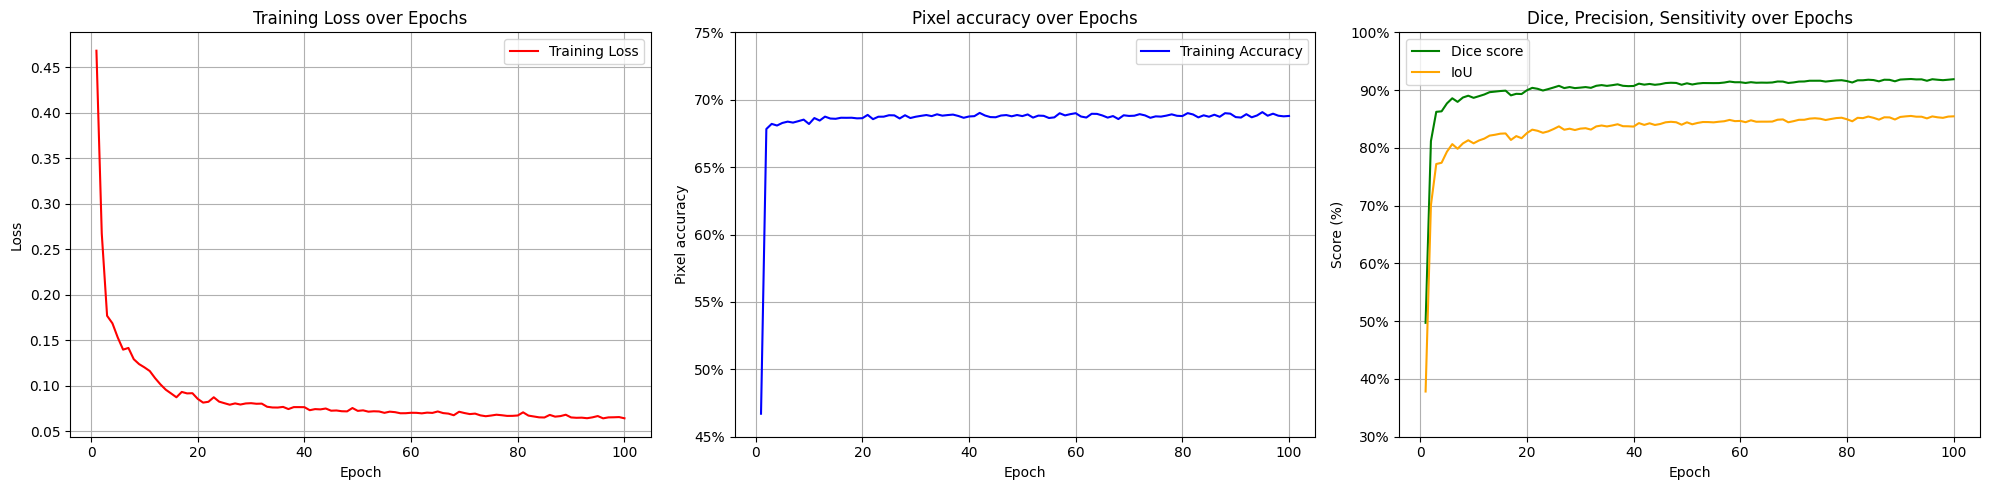

In [627]:
'''---Plotting and Visualizing convergence---'''
it=np.arange(epochs)+1
plt.figure(figsize=(20,5))

'''--- Training loss ---'''
plt.subplot(131)
plt.title('Training Loss over Epochs')
plt.plot(it, train_losses, label='Training Loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

'''--- Pixel Accuracy ---'''
ax2 = plt.subplot(132) 
plt.title('Pixel accuracy over Epochs')
plt.plot(it, train_accuracies, label='Training Accuracy', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Pixel accuracy')
plt.grid(True)
plt.legend()

ticks2 = ax2.get_yticks()
ax2.set_yticks(ticks2)
ax2.set_yticklabels(['{:.0f}%'.format(x*100) for x in ticks2])


'''--- Dice, Precision, Sensitivity ---'''
ax3 = plt.subplot(133) 
plt.title('Dice, Precision, Sensitivity over Epochs')
plt.plot(it, train_dice_score, label='Dice score', color = 'green')
plt.plot(it, train_iou,label = 'IoU', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.grid(True)
plt.legend()

ticks3 = ax3.get_yticks()
ax3.set_yticks(ticks3)
ax3.set_yticklabels(['{:.0f}%'.format(x*100) for x in ticks3])

plt.tight_layout()
plt.show()

### Run test samples on trained model

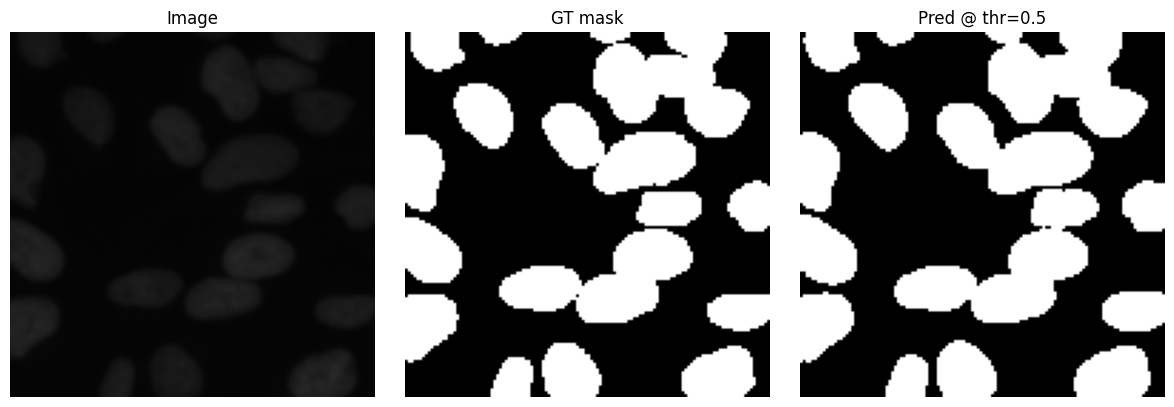

In [672]:
'''Visualizing Segmented Output'''

#DataLoader returns (batch_size,3,H,W) for img and (batch_size,1,H,W) for mask
eval_dl = DataLoader(DSB2018_Dataset(set_type='eval'), batch_size=1, shuffle=True) 

# ---Get one sample---
img, mask = next(iter(eval_dl)) # img: [B,3,H,W], mask: [B,1,H,W] 
img  = img.to(device)
mask = mask.to(device)

if mask.ndim == 4 and mask.shape[1] == 1: mask = mask[:, 0] # -> [B,H,W]
elif mask.ndim != 3:
    raise ValueError("mask must be [B,1,H,W] or [B,H,W] for binary")

# ---Normalized test input---
img_norm = TF.normalize(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# --- Handling Deep Supervision and W/O Deep Supervision ---
head_weights = [0.1,0.1,0.2,0.6]
thr = 0.5
model.eval()
with torch.no_grad(): 
    model.deep_supervision= True
    out = model(img_norm) # logits [B,1,H,W] or list of 4 [B,1,H,W]

    #---Deep supervision---
    #Average heads with weights, consistent with the head weights used in loss
    if isinstance(out, (list, tuple)):
        heads = []
        for idx,o in enumerate(out):
            if o.ndim == 4 and o.shape[1] == 1:      # [B,1,H,W]
                heads.append(o[:, 0]*head_weights[idx])                # [B,H,W]
            else: raise ValueError(f"Unexpected head shape: {o.shape}")

        logit = torch.stack(heads, dim=0).mean(dim=0)   # [B,H,W]
    
    #---W/O Deep supervision---
    else:
        if out.ndim == 4 and out.shape[1] == 1:
            logit = out[:, 0,:,:]                         # [B,H,W]
        else: raise ValueError(f"Unexpected output shape: {out.shape}")

    prob = torch.sigmoid(logit)                     # [B,H,W] in [0,1]
    pred = (prob >= thr).float()                     # hard mask [B,H,W]

# ---Convert to CPU---
img_vis  = img[0].detach().permute(1,2,0).cpu().numpy()   # [H,W,3]
mask_vis = mask[0].detach().float().cpu().numpy()         # [H,W]
pred_vis = pred[0].detach().cpu().numpy()                 # [H,W]

# ---Plotting---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_vis)                        
axs[0].set_title("Image")       
axs[0].axis('off')

axs[1].imshow(mask_vis, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("GT mask")
axs[1].axis('off')

axs[2].imshow(pred_vis, cmap='gray', vmin=0, vmax=1)
axs[2].set_title(f"Pred @ thr={thr}")
axs[2].axis('off')

plt.tight_layout(); plt.show()



In [ ]:
# torch.save(model.state_dict(), '../LiteUNet3Plus.pth')